In [9]:
import pandas as pd
import kagglehub
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, learning_curve
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, roc_curve, confusion_matrix, precision_recall_fscore_support
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.naive_bayes import GaussianNB
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from lightgbm import LGBMClassifier
import shap
!pip install catboost
from catboost import CatBoostClassifier
from sklearn.multioutput import MultiOutputClassifier
import joblib
!pip install dask[dataframe]
import dask.dataframe as dd

#downloading a cleaned version of UCI dataset
path = kagglehub.dataset_download("ritwikb3/heart-disease-cleveland")
print("Path to dataset files:", path)

cleveland_df = pd.read_csv(f'{path}/Heart_disease_cleveland_new.csv')

#checking the first few rows to understand the structure
print(cleveland_df.head())
print(cleveland_df.columns)


Path to dataset files: /root/.cache/kagglehub/datasets/ritwikb3/heart-disease-cleveland/versions/1
   age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  slope  \
0   63    1   0       145   233    1        2      150      0      2.3      2   
1   67    1   3       160   286    0        2      108      1      1.5      1   
2   67    1   3       120   229    0        2      129      1      2.6      1   
3   37    1   2       130   250    0        0      187      0      3.5      2   
4   41    0   1       130   204    0        2      172      0      1.4      0   

   ca  thal  target  
0   0     2       0  
1   3     1       1  
2   2     3       1  
3   0     1       0  
4   0     1       0  
Index(['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
       'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target'],
      dtype='object')


In [10]:
#checking for missing values
cleveland_df.isnull().sum()

#handle categorical columns by mapping them
cleveland_df['sex'] = cleveland_df['sex'].map({1: 'Male', 0: 'Female'})
cleveland_df['cp'] = cleveland_df['cp'].map({0: 'typical angina', 1: 'atypical angina', 2: 'non_anginal pain', 3: 'asymptomatic'})
cleveland_df['fbs'] = cleveland_df['fbs'].map({0: 'False', 1: 'True'})
cleveland_df['restecg'] = cleveland_df['restecg'].map({0: 'Normal', 1: 'ST-T wave abnormality', 2: 'left ventricular hypertrophy'})
cleveland_df['exang'] = cleveland_df['exang'].map({0: 'No', 1: 'Yes'})
cleveland_df['slope'] = cleveland_df['slope'].map({0: 'up', 1: 'flat', 2: 'down'})
cleveland_df['thal'] = cleveland_df['thal'].map({1: 'normal', 2: 'fixed defect', 3: 'reversible defect'})

#create indicators for all 8 disease types
def create_disease_indicators(row):
    disease_types = {
        'Non_Anginal Pain': 0,
        'Stable Angina (Typical Angina)': 0,
        'Unstable Angina (Atypical Angina)': 0,
        'Asymptomatic Heart Disease': 0,
        'Left Ventricular Hypertrophy': 0,
        'Myocardial Infarction (Heart Attack)': 0,
        'Coronary Artery Disease (CAD)': 0,
        'Hypertensive Heart Disease': 0
    }
    if row['cp'] == 'typical angina':
        disease_types['Stable Angina (Typical Angina)'] = 1
    elif row['cp'] == 'atypical angina':
        disease_types['Unstable Angina (Atypical Angina)'] = 1
    elif row['cp'] == 'non_anginal pain':
        disease_types['Non_Anginal Pain'] = 1
    elif row['cp'] == 'asymptomatic':
        disease_types['Asymptomatic Heart Disease'] = 1

    if row['restecg'] == 'left ventricular hypertrophy':
        disease_types['Left Ventricular Hypertrophy'] = 1

    if row['thal'] == 'reversible defect':
        disease_types['Myocardial Infarction (Heart Attack)'] = 1

    if row['chol'] > 240:
        disease_types['Coronary Artery Disease (CAD)'] = 1

    if row['trestbps'] > 140:
        disease_types['Hypertensive Heart Disease'] = 1

    return pd.Series(disease_types)

#creating binary indicators for each disease
disease_indicators = cleveland_df.apply(create_disease_indicators, axis=1)
cleveland_df = pd.concat([cleveland_df, disease_indicators], axis=1)

#saving original disease indicators before get_dummies
disease_cols = ['Non_Anginal Pain', 'Stable Angina (Typical Angina)',
                'Unstable Angina (Atypical Angina)', 'Asymptomatic Heart Disease',
                'Left Ventricular Hypertrophy', 'Myocardial Infarction (Heart Attack)',
                'Coronary Artery Disease (CAD)', 'Hypertensive Heart Disease']
y_disease = cleveland_df[disease_cols].copy()

cleveland_df = pd.get_dummies(cleveland_df.drop(disease_cols, axis=1), drop_first=True)

cleveland_df.columns = cleveland_df.columns.str.replace(' ', '_')
X_cleveland = cleveland_df.drop(['target'], axis=1) if 'target' in cleveland_df.columns else cleveland_df

#trying feature engineering here with polynomial features
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_poly = poly.fit_transform(X_cleveland)

#scaling the features
scaler = StandardScaler()
numerical_columns = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']
X_cleveland[numerical_columns] = scaler.fit_transform(X_cleveland[numerical_columns])


Logistic Regression on Cleveland Dataset (First disease):
Accuracy: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        65
           1       1.00      1.00      1.00        26

    accuracy                           1.00        91
   macro avg       1.00      1.00      1.00        91
weighted avg       1.00      1.00      1.00        91

SVM on Cleveland Dataset (First disease):
Accuracy: 0.967032967032967
              precision    recall  f1-score   support

           0       0.96      1.00      0.98        65
           1       1.00      0.88      0.94        26

    accuracy                           0.97        91
   macro avg       0.98      0.94      0.96        91
weighted avg       0.97      0.97      0.97        91

KNN on Cleveland Dataset (First disease):
Accuracy: 0.8681318681318682
              precision    recall  f1-score   support

           0       0.85      0.98      0.91        65
           1       0.94 

<Figure size 1000x800 with 0 Axes>

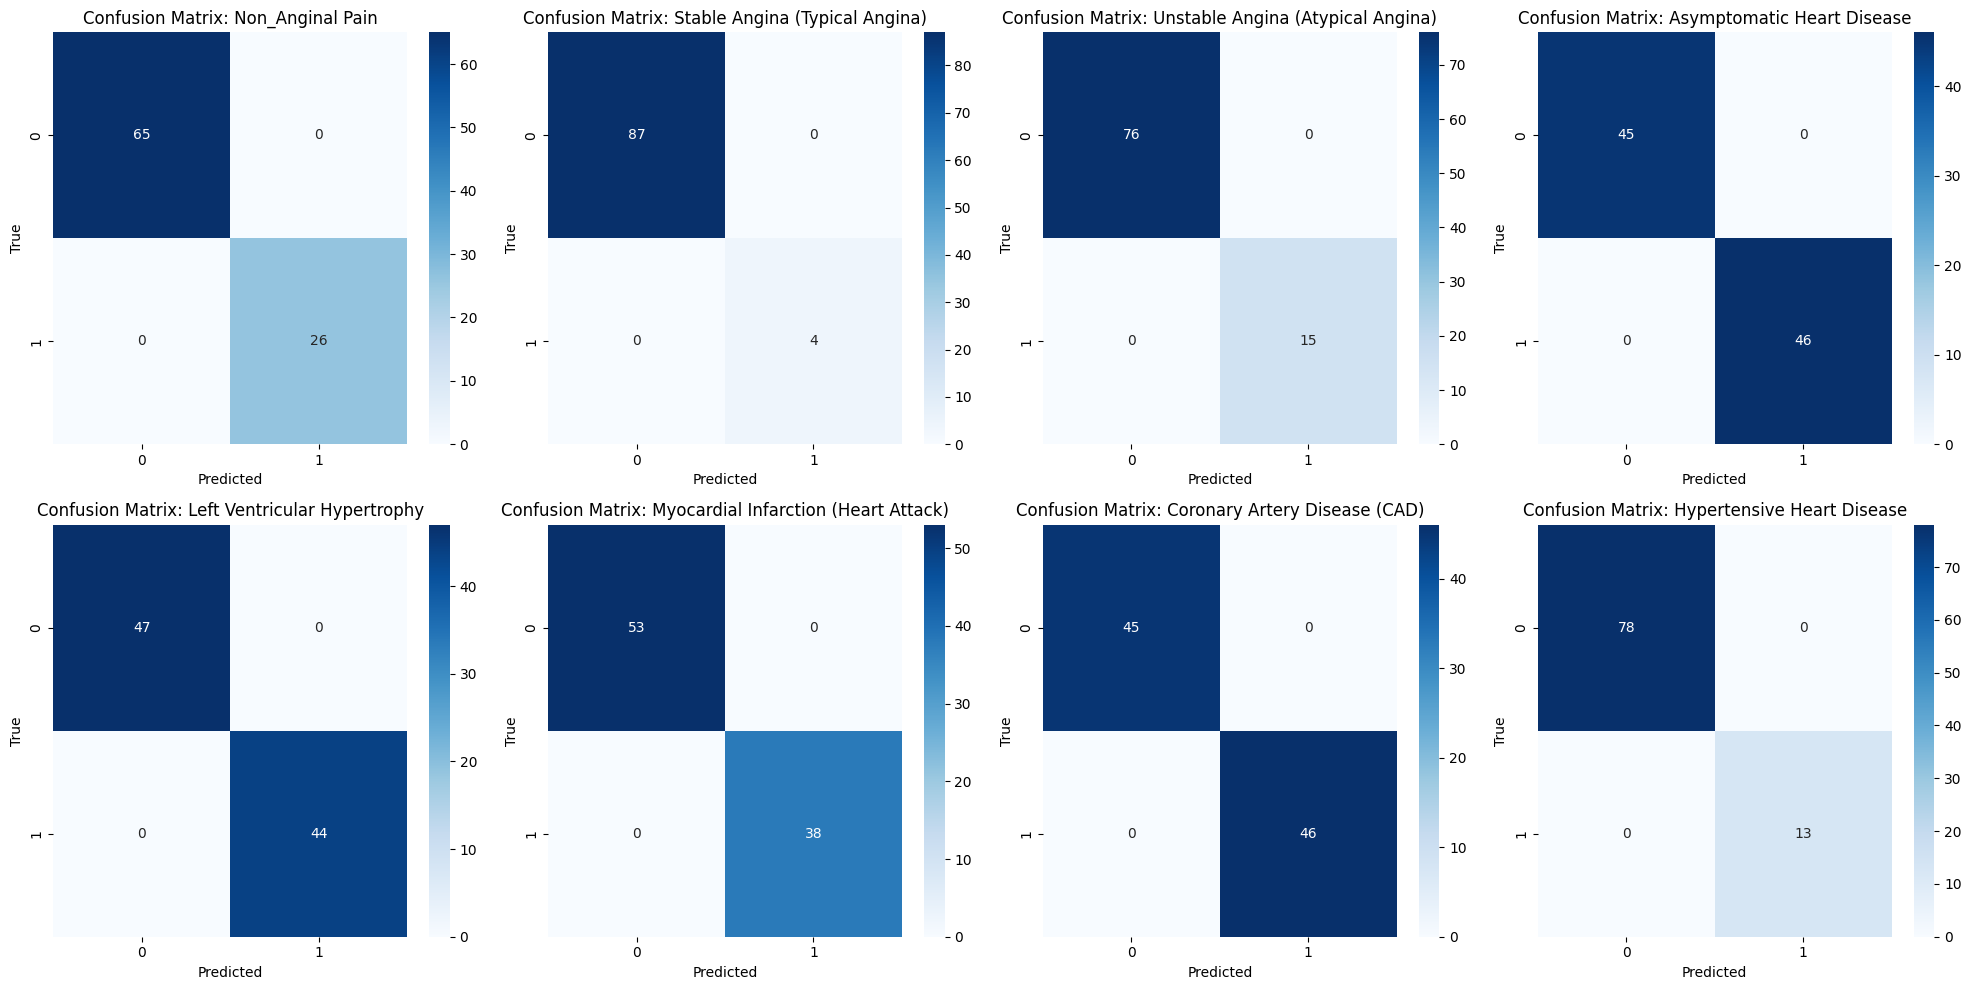

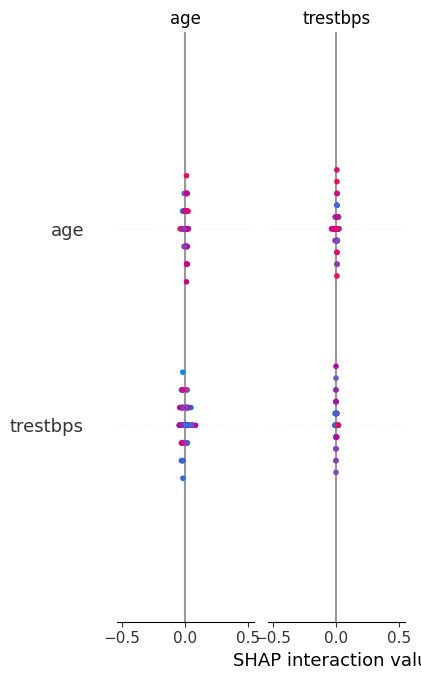

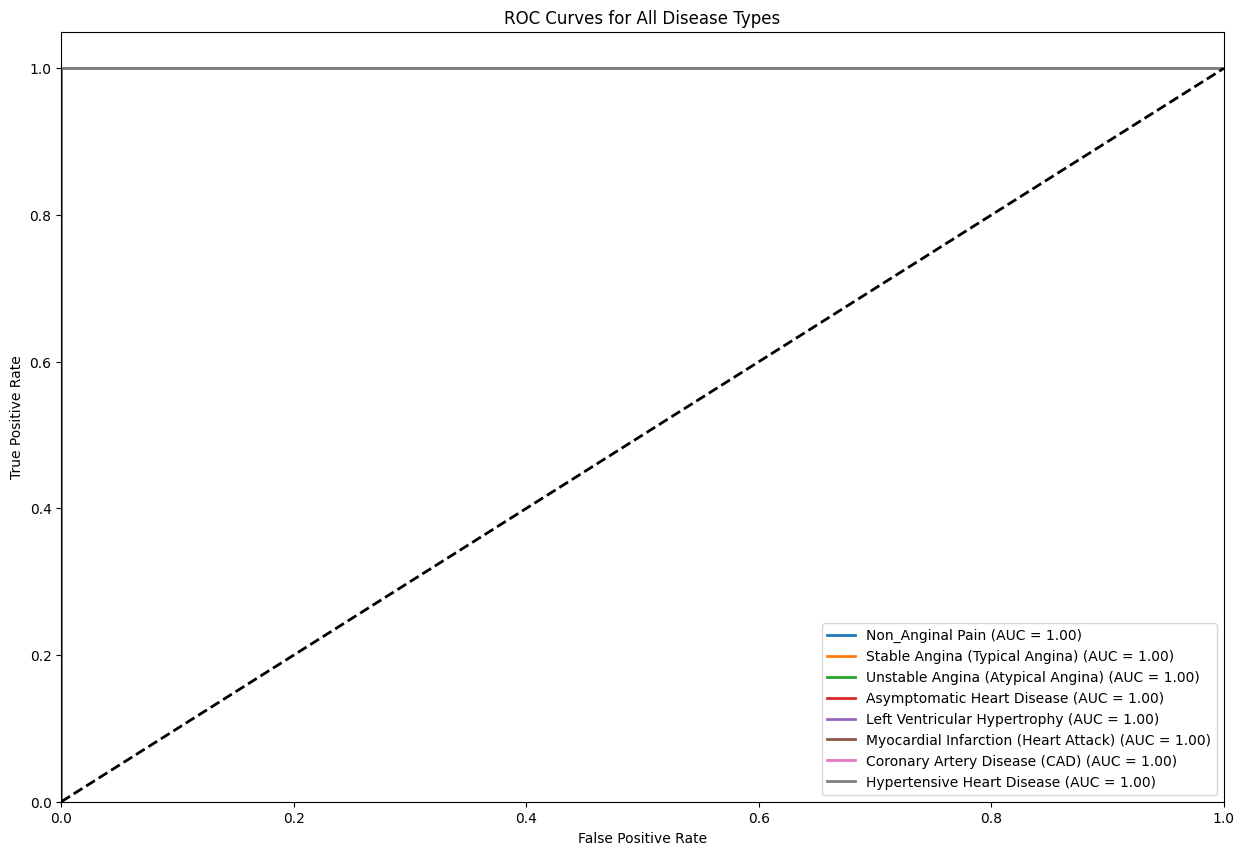

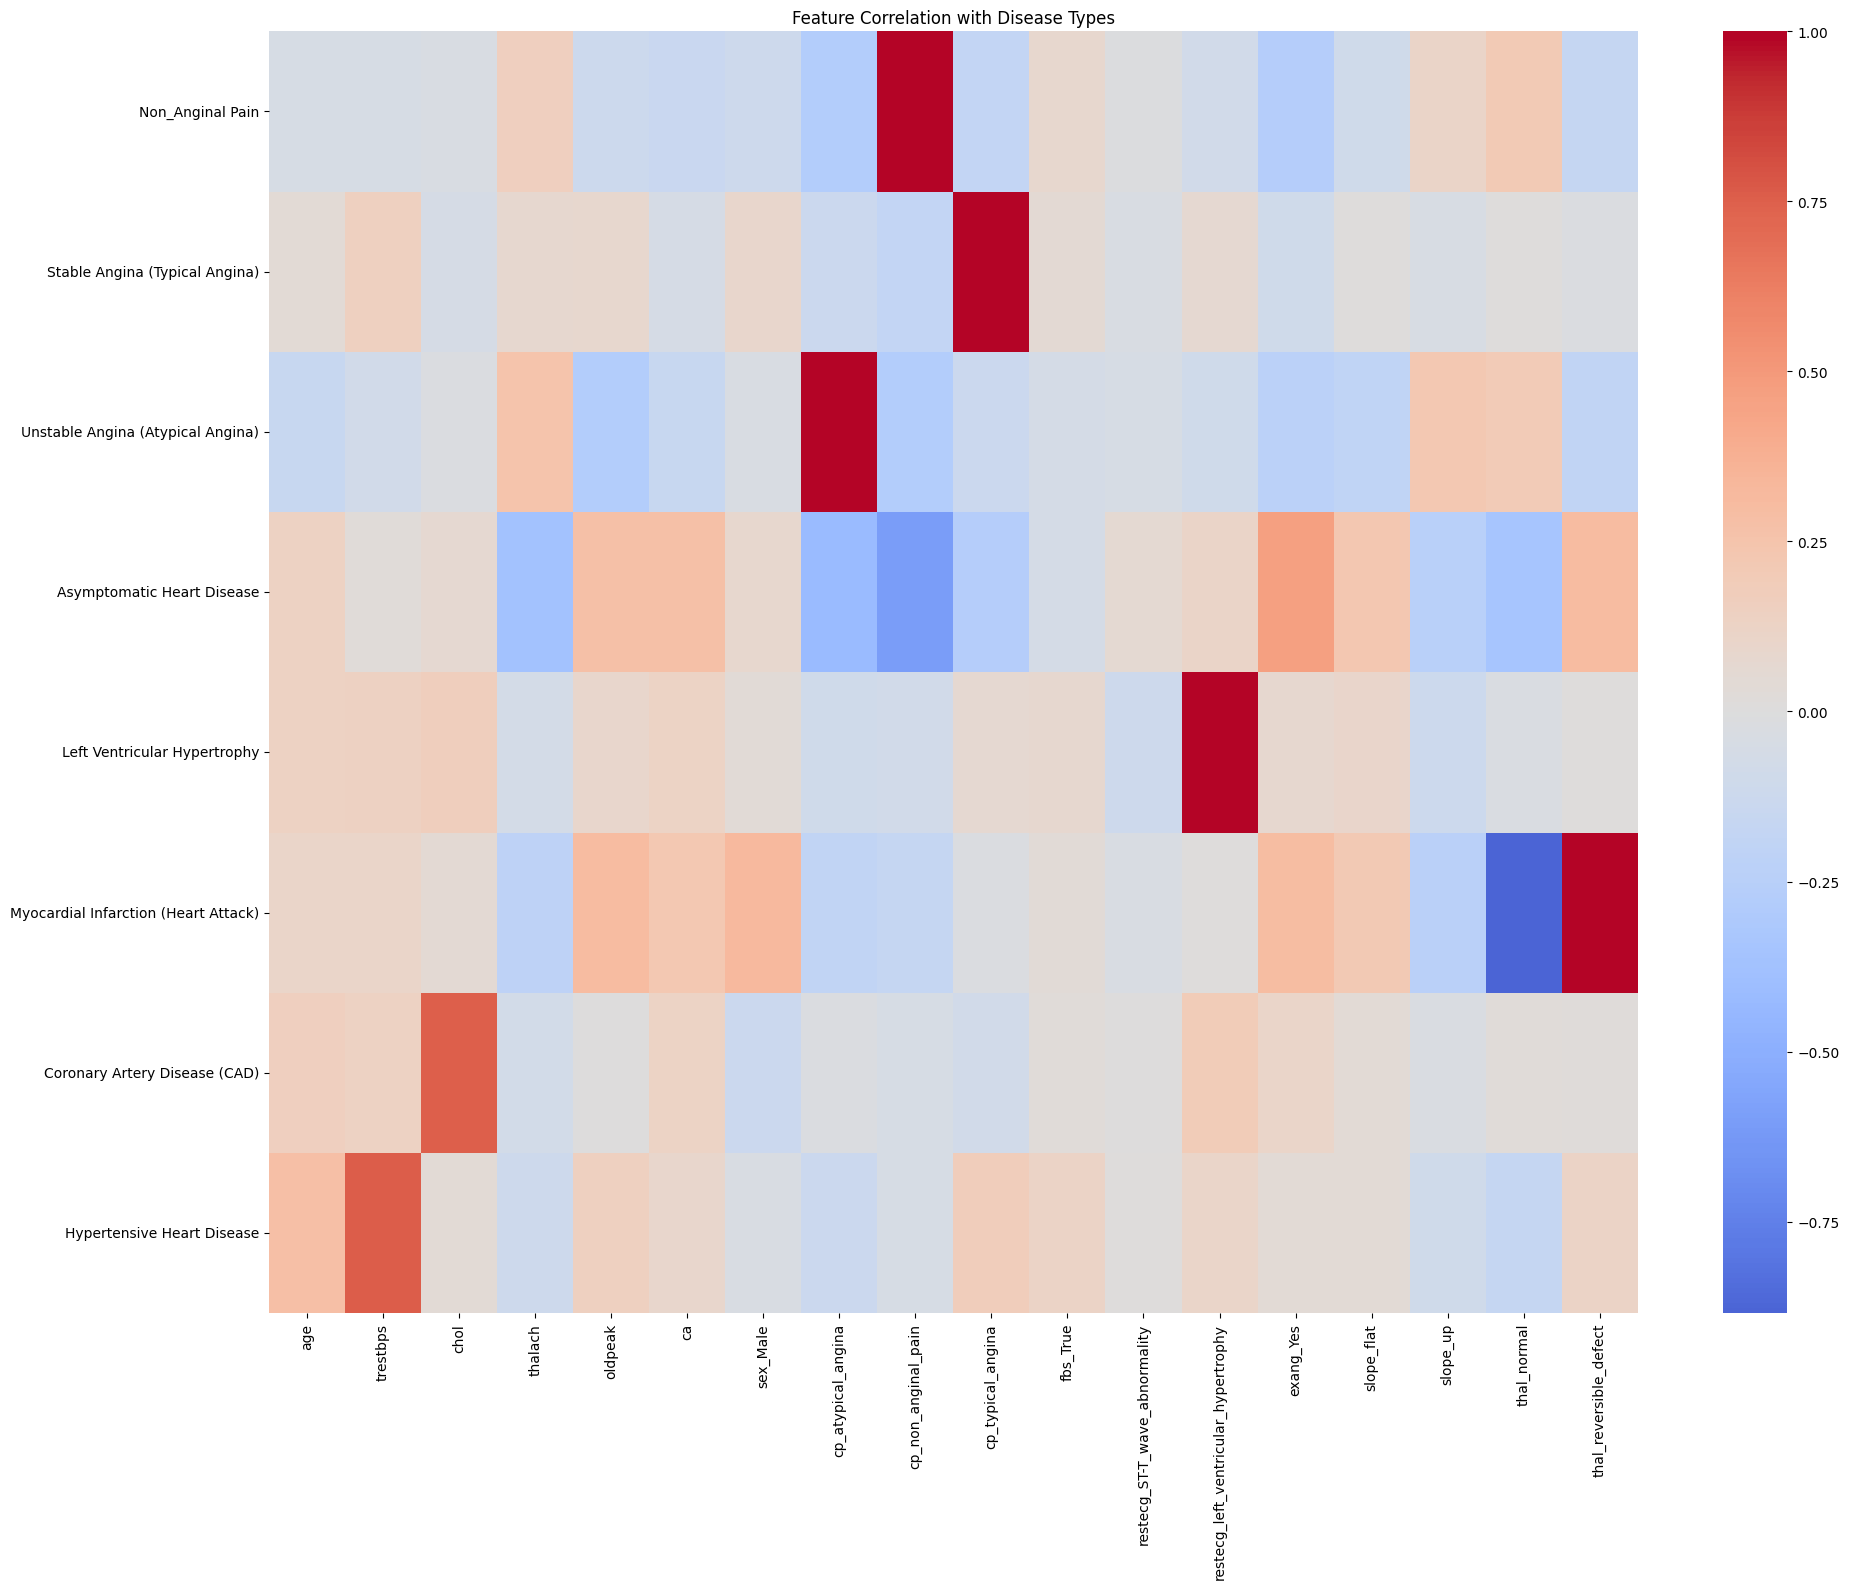

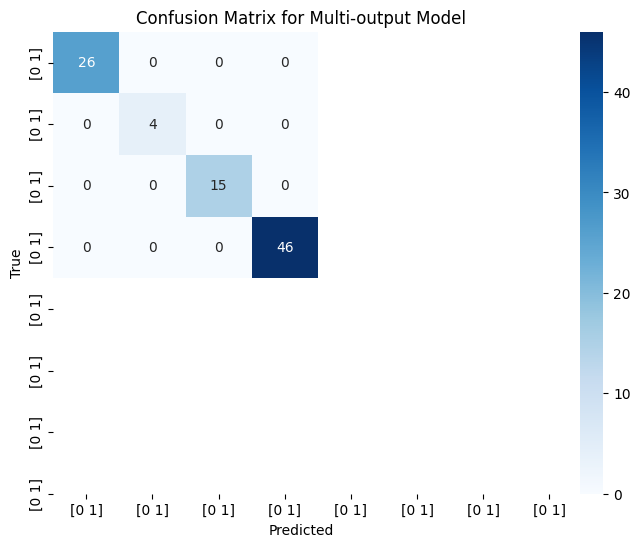

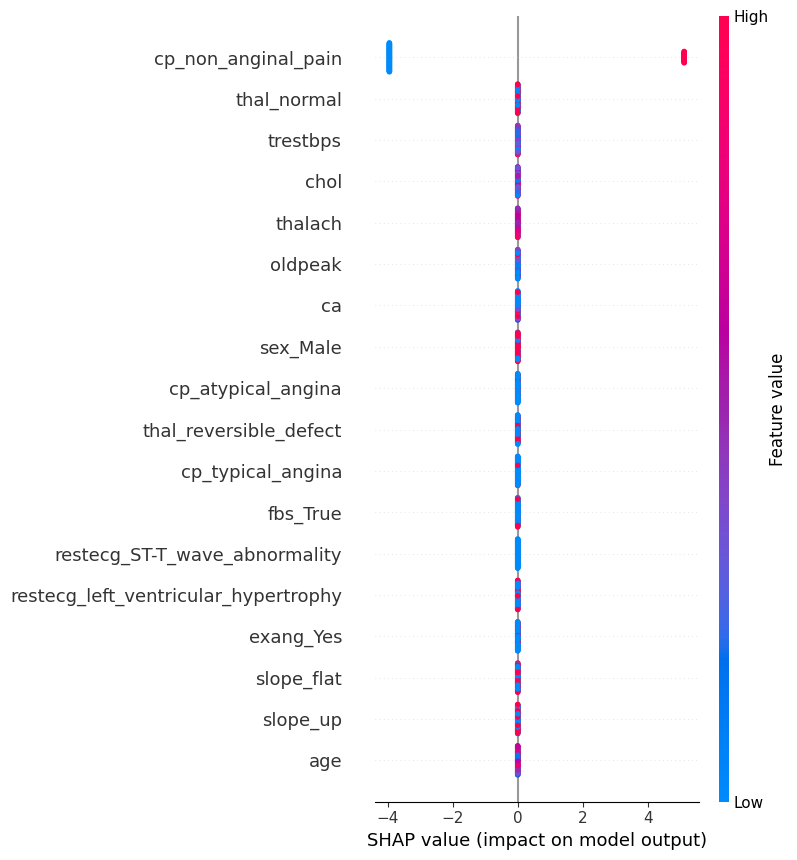

/usr/local/lib/python3.11/dist-packages/shap/plots/_force_matplotlib.py:101: RuntimeWarning: divide by zero encountered in scalar divide
  feature_contribution = np.abs(float(feature[0]) - pre_val) / np.abs(total_effect)


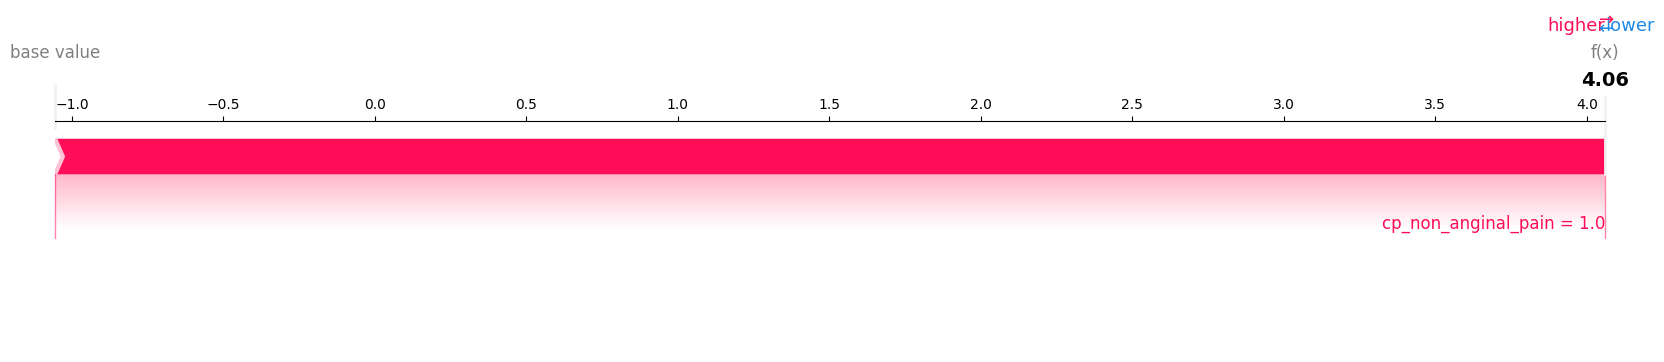

In [11]:
import warnings
warnings.filterwarnings('ignore', category=UserWarning)

#splitting the dataset into train and test
X_train_cleveland, X_test_cleveland, y_train_cleveland, y_test_cleveland = train_test_split(
    X_cleveland, y_disease, test_size=0.3, random_state=42)

models = {
    "Logistic Regression": LogisticRegression(),
    "SVM": SVC(probability=True),
    "KNN": KNeighborsClassifier(),
    "XGBoost": xgb.XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=5,
                                 use_label_encoder=False, eval_metric='logloss'),
    "LightGBM": LGBMClassifier(),
    "CatBoost": CatBoostClassifier(silent=True),
    "Naive Bayes": GaussianNB()
}
plt.figure(figsize=(10, 8))

#for single-output model evaluations
for model_name, model in models.items():
    try:
        model.fit(X_train_cleveland, y_train_cleveland.iloc[:, 0])
        y_pred_cleveland = model.predict(X_test_cleveland)

        print(f"{model_name} on Cleveland Dataset (First disease):")
        print("Accuracy:", accuracy_score(y_test_cleveland.iloc[:, 0], y_pred_cleveland))
        print(classification_report(y_test_cleveland.iloc[:, 0], y_pred_cleveland))
    except Exception as e:
        print(f"Skipping {model_name} due to error: {e}")

#multi-output classifier(random forest for all 8 disease types)
multi_output_model = MultiOutputClassifier(
    RandomForestClassifier(n_estimators=100, max_depth=20, random_state=42))

multi_output_model.fit(X_train_cleveland, y_train_cleveland)
y_pred_multi = multi_output_model.predict(X_test_cleveland)

print("Multi-output Model Classification Report:")
for i, disease in enumerate(disease_cols):
    print(f"\nClassification Report for {disease}:")
    print(classification_report(y_test_cleveland.iloc[:, i], y_pred_multi[:, i]))

accuracy_scores = [accuracy_score(y_test_cleveland.iloc[:, i], y_pred_multi[:, i])
                   for i in range(y_test_cleveland.shape[1])]

for i, score in enumerate(accuracy_scores):
    print(f"Accuracy for {disease_cols[i]}: {score:.4f}")

for model_name, model in models.items():
    joblib.dump(model, f'{model_name}_model.pkl')

joblib.dump(multi_output_model, 'multi_output_model.pkl')

joblib.dump(scaler, 'scaler.pkl')

with open('disease_columns.txt', 'w') as f:
    for disease in disease_cols:
        f.write(f"{disease}\n")

#plotting confusion matrices for each disease type
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

for i, (disease, ax) in enumerate(zip(disease_cols, axes)):
    cm = confusion_matrix(y_test_cleveland.iloc[:, i], y_pred_multi[:, i])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
    ax.set_title(f'Confusion Matrix: {disease}')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')

plt.tight_layout()
plt.show()

#plotting SHAP for feature importance
rf_explainer = shap.TreeExplainer(multi_output_model.estimators_[0])
rf_shap_values = rf_explainer.shap_values(X_test_cleveland)
shap.summary_plot(rf_shap_values, X_test_cleveland, plot_type="bar")

#ROC curves for all disease types
plt.figure(figsize=(15, 10))
for i, disease in enumerate(disease_cols):
    y_prob = multi_output_model.estimators_[i].predict_proba(X_test_cleveland)[:, 1]
    fpr, tpr, _ = roc_curve(y_test_cleveland.iloc[:, i], y_prob)
    roc_auc = roc_auc_score(y_test_cleveland.iloc[:, i], y_prob)
    plt.plot(fpr, tpr, lw=2, label=f'{disease} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for All Disease Types')
plt.legend(loc="lower right")
plt.show()

#plotting feature correlation with disease types
corr_matrix = pd.concat([X_cleveland, y_disease], axis=1).corr()
plt.figure(figsize=(20, 16))
sns.heatmap(corr_matrix.loc[disease_cols, X_cleveland.columns],
            annot=False, cmap='coolwarm', center=0)
plt.title('Feature Correlation with Disease Types')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

conf_matrix = confusion_matrix(y_test_cleveland.values.argmax(axis=1), y_pred_multi.argmax(axis=1))
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=multi_output_model.classes_, yticklabels=multi_output_model.classes_)
plt.title('Confusion Matrix for Multi-output Model')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

#plotting SHAP for XGBoost
xgb_model = xgb.XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=5, use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train_cleveland, y_train_cleveland.iloc[:, 0])
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_test_cleveland)
shap.summary_plot(shap_values, X_test_cleveland)
shap.initjs()

expected_value = explainer.expected_value
if isinstance(expected_value, list):
    expected_value = expected_value[0]

if isinstance(shap_values, list):
    instance_shap_values = shap_values[0]
else:
    instance_shap_values = shap_values
shap.force_plot(expected_value,
                instance_shap_values[0,:],
                X_test_cleveland.iloc[0,:],
                feature_names=list(X_test_cleveland.columns),
                matplotlib=True)
plt.show()


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 1, number of negative: 15
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 16, number of used features: 0
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.062500 -> initscore=-2.708050
[LightGBM] [Info] Start training from score -2.708050
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because th

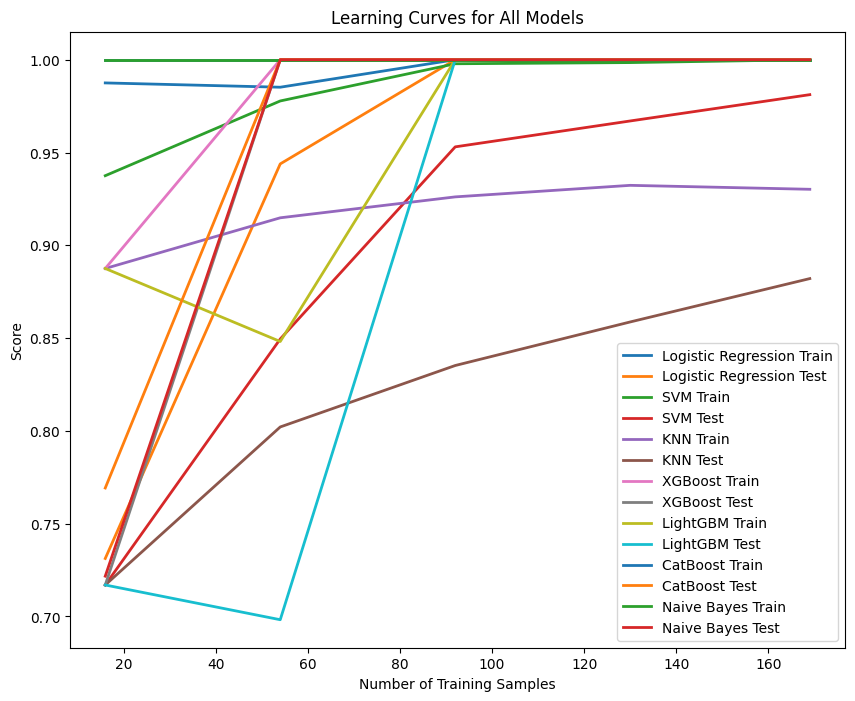

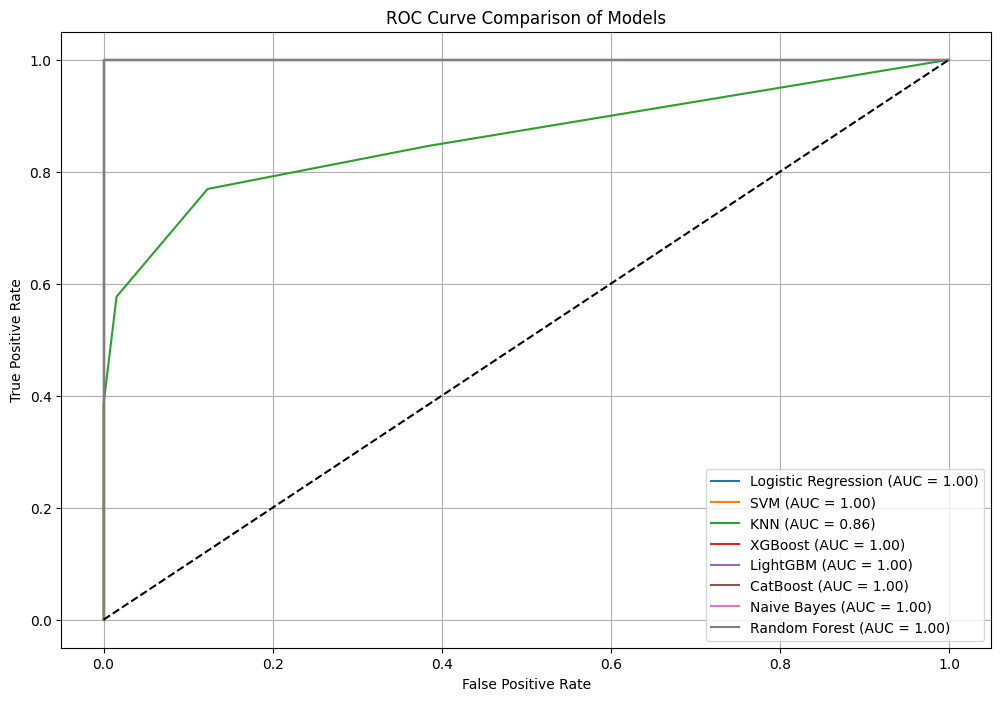

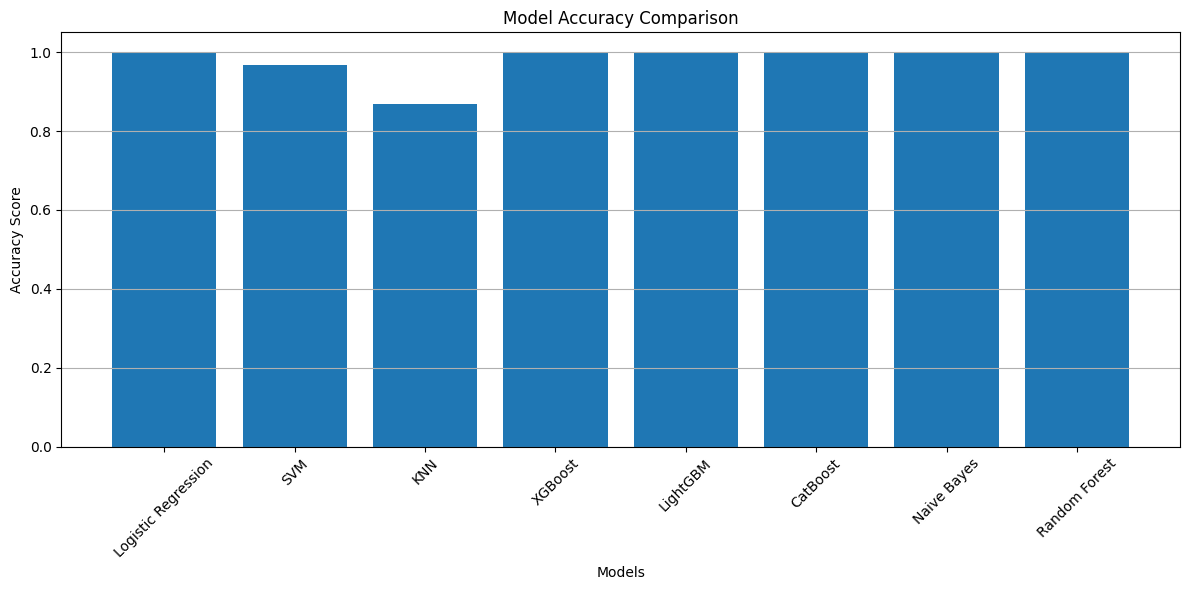

In [12]:
#plotting learning curve
plt.figure(figsize=(10, 8))

for model_name, model in models.items():
    try:
        #to avoid the compatibility error between different versions of libraries, i'm only plotting learning curves for models that work with sklearn's learning curve
        train_sizes, train_scores, test_scores = learning_curve(model, X_train_cleveland, y_train_cleveland.iloc[:, 0], cv=5, n_jobs=1)
        plt.plot(train_sizes, train_scores.mean(axis=1), label=f'{model_name} Train', lw=2)
        plt.plot(train_sizes, test_scores.mean(axis=1), label=f'{model_name} Test', lw=2)
    except Exception as e:
        print(f"Skipping {model_name} due to error: {e}")

plt.title('Learning Curves for All Models')
plt.xlabel('Number of Training Samples')
plt.ylabel('Score')
plt.legend()
plt.show()

#plotting ROC curve comparison of models
plt.figure(figsize=(12, 8))
for model_name, model in models.items():
    if model_name != "Random Forest":
        try:
            y_prob = model.predict_proba(X_test_cleveland)[:, 1]
            fpr, tpr, _ = roc_curve(y_test_cleveland.iloc[:, 0], y_prob)
            roc_auc = roc_auc_score(y_test_cleveland.iloc[:, 0], y_prob)
            plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')
        except Exception as e:
            print(f"Skipping ROC curve for {model_name} due to error: {e}")

rf_prob = multi_output_model.estimators_[0].predict_proba(X_test_cleveland)[:, 1]
fpr_rf, tpr_rf, _ = roc_curve(y_test_cleveland.iloc[:, 0], rf_prob)
roc_auc_rf = roc_auc_score(y_test_cleveland.iloc[:, 0], rf_prob)
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {roc_auc_rf:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison of Models')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

#plotting model accuracy comparison
plt.figure(figsize=(12, 6))
model_accuracies = {}

for model_name, model in models.items():
    if model_name != "Random Forest":
        try:
            y_pred = model.predict(X_test_cleveland)
            accuracy = accuracy_score(y_test_cleveland.iloc[:, 0], y_pred)
            model_accuracies[model_name] = accuracy
        except Exception as e:
            print(f"Skipping accuracy calculation for {model_name} due to error: {e}")

rf_accuracy = accuracy_score(y_test_cleveland.iloc[:, 0], y_pred_multi[:, 0])
model_accuracies["Random Forest"] = rf_accuracy

plt.bar(range(len(model_accuracies)), list(model_accuracies.values()))
plt.xticks(range(len(model_accuracies)), list(model_accuracies.keys()), rotation=45)
plt.title('Model Accuracy Comparison')
plt.xlabel('Models')
plt.ylabel('Accuracy Score')
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()


In [13]:
for model_name, model in models.items():
    joblib.dump(model, f'{model_name}_model.pkl')

joblib.dump(multi_output_model, 'multi_output_model.pkl')
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(poly, 'poly.pkl')

from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(drop='first', sparse_output=False)
categorical_features = X_cleveland.select_dtypes(include=['object', 'category']).columns
encoder.fit(X_train_cleveland[categorical_features])

joblib.dump(encoder, 'encoder.pkl')


['encoder.pkl']

In [14]:
import joblib
poly = joblib.load('poly.pkl')
print("Training features:", poly.get_feature_names_out())


Training features: ['age' 'trestbps' 'chol' 'thalach' 'oldpeak' 'ca' 'sex_Male'
 'cp_atypical_angina' 'cp_non_anginal_pain' 'cp_typical_angina' 'fbs_True'
 'restecg_ST-T_wave_abnormality' 'restecg_left_ventricular_hypertrophy'
 'exang_Yes' 'slope_flat' 'slope_up' 'thal_normal'
 'thal_reversible_defect' 'age trestbps' 'age chol' 'age thalach'
 'age oldpeak' 'age ca' 'age sex_Male' 'age cp_atypical_angina'
 'age cp_non_anginal_pain' 'age cp_typical_angina' 'age fbs_True'
 'age restecg_ST-T_wave_abnormality'
 'age restecg_left_ventricular_hypertrophy' 'age exang_Yes'
 'age slope_flat' 'age slope_up' 'age thal_normal'
 'age thal_reversible_defect' 'trestbps chol' 'trestbps thalach'
 'trestbps oldpeak' 'trestbps ca' 'trestbps sex_Male'
 'trestbps cp_atypical_angina' 'trestbps cp_non_anginal_pain'
 'trestbps cp_typical_angina' 'trestbps fbs_True'
 'trestbps restecg_ST-T_wave_abnormality'
 'trestbps restecg_left_ventricular_hypertrophy' 'trestbps exang_Yes'
 'trestbps slope_flat' 'trestbps sl

In [15]:
print("y_disease columns:", y_disease.columns)
print("y_disease shape:", y_disease.shape)

multi_output_model = MultiOutputClassifier(
    RandomForestClassifier(n_estimators=100, max_depth=20, random_state=42))
multi_output_model.fit(X_train_cleveland, y_train_cleveland)

print("Number of estimators:", len(multi_output_model.estimators_))


y_disease columns: Index(['Non_Anginal Pain', 'Stable Angina (Typical Angina)',
       'Unstable Angina (Atypical Angina)', 'Asymptomatic Heart Disease',
       'Left Ventricular Hypertrophy', 'Myocardial Infarction (Heart Attack)',
       'Coronary Artery Disease (CAD)', 'Hypertensive Heart Disease'],
      dtype='object')
y_disease shape: (303, 8)
Number of estimators: 8
